# Final Project - Lucas Allen

### In canopy radiative transfer (CRT) models, how much does precise information about leaf orientation and scattering phase functions matter?

Most CRT models assume that all scattering is isotropic. This is not true, but does it really make a big difference?

For Machine Learning emulation of CRT models, what are the most important parameters?

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.integrate as integrate
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestRegressor

import random

As a part of an (independent of 573) research credit, I built a CRT model. This is the source of all the data used in this notebook. You can find the (admittedly poorly commented and documented) files on my personal Github account lallen29. 

To get some of the data, I randomized inputs to the model. For completeness/transparency, the code to do this is outlined in the Jupyter Notebook gen_random_data.ipynb, though it won't run because I don't have the appropriate model imported.

The CRT model utilizes Scipy to perform some integrations and solve BVPs. I'll briefly go over how Scipy is used.

An important part of CRT models is the leaf orientation function. This is a probability density function which describes the probability that the outward surface normal of a leaf points at some cosine of angle off of vertical. An example is the planophile orientation function, in which leaves are biased to be more horizontal.

In [2]:
pi = np.pi

# mu=1 is vertical up, mu=-1 is vertical down
def planophile(mu):

    theta = np.arccos(abs(mu))
    theta = pi / 2 - theta

    return 1 / pi * (1 + np.cos(2 * theta)) / (np.sqrt(1 - mu ** 2))

Let's use scipy to perform some integrals. We check that the PDF integrates to 1, and we find the mean leaf angle (MLA) in degrees off of horizontal.

In [3]:
# regular integral
integral = integrate.quad(lambda mu: planophile(mu), -1, 1)[0]

# careful converting from degrees to radians!
mla = integrate.quad(lambda mu: (np.pi / 2 - np.arccos(np.abs(mu)))  * planophile(mu), -1, 1)[0] * 180 / pi

print(integral)
print(mla)

1.0000000000000004
26.762186944379213


Now let's use scipy to solve a BVP. We use a simple version of what is in my model. Suppose we have some incoming diffuse radiation at the top of the canopy. If we keep track of the radiation in 2 streams, upward and downward, we can formulate a BVP, the solution of which is the (approximate) disposition of sunlight in the canopy.

Full derivation as part of my research project, if you're curious: https://www.overleaf.com/read/cvwmykvxgmnt#40c198

In [4]:
'''
we need a matrix to describe how scattering works.
Let the i,j entry of the geo_r matrix describe the probability that a photon from the i direction is 
scattered into the j direction by reflection off the leaf surface

Let the i,j entry of the geo_t matrix describe the probability that a photon from the i direction is 
scattered into the j direction by transmission through the leaf surface

i,j=0 is the upward direction, i,j=1 is the downward direction
'''

geo_r = np.array([[0.15, 0.35],
                  [0.35, 0.15]])

geo_t = np.array([[0.35, 0.15],
                  [0.15, 0.35]])

r = 0.4 # a photon is reflected from a leaf with probability 0.4
t = 0.3 # a photon is transmitted through a leaf with probability 0.3

# set up the differential equation
def dI_dlai(dlai, I):
    """
    dlai: Leaf Area Index (LAI) in this layer
    I: Intensity
    """

    results = np.zeros((2, len(dlai)))

    # for each stream, compute sources, sinks
    for i in range(2):
        result = 0

        # how much Irradiance hits a leaf. suppose 0.5 is stream-average projected leaf area value
        sink = I[i] * 0.5

        # source terms: how much Irradiance enters the stream after begin scattered from any stream
        dif_r = 0
        for j in range(2):
            dif_r += I[j] * geo_r[i, j]

        dif_t = 0
        for j in range(2):
            dif_t += I[j] * geo_t[i, j]

        result = -sink + r * (dif_r) + t * (dif_t)

        # scale by how likely to hit a leaf (layer thickness in LAI)
        result *= dlai

        # correct sign
        if i == 0:
            result = -result
            
        results[i] = result

    return results

'''
We also need boundary conditions

Top of canopy (toc) is the downward diffuse radiation, set to 1

Bottom of canopy (boc) is the soil reflectance, say 0.2, times the downward intensity 
'''
def calc_bcs(toc, boc):

        residuals = np.zeros(2)

        # first stream (upward) has a bc at soil
        # we assume isotropic reflection off of soil surface from streams and direct beam
        downward_flux = boc[1] * pi

        reflected_flux = downward_flux * 0.2
        reflected_isotropic_intensity = reflected_flux / pi

        # find residual error
        residuals[0] = boc[0] - reflected_isotropic_intensity

        # second stream (downward) as a bc at toc due to diffuse, say we have 1 w/m^2 incoming
        residuals[1] = toc[1] - 1

        return residuals



In [5]:
# set lai. 0 at top of canopy, increases downward
x = np.linspace(0,5,100)

# requires initial guess
y0 = np.ones((2, x.size))

# actually solve the BVP with scipy
result = integrate.solve_bvp(lambda lai, I: dI_dlai(lai, I),
                            lambda toc_I, boc_I: calc_bcs(toc_I, boc_I), 
                             x, y0,)

y = result.sol(x)  # solution at x vals

Great! Let's make a quick plot to see what they look like

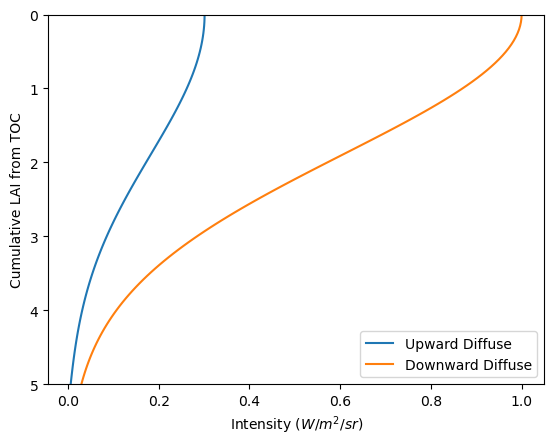

In [6]:
plt.plot(y[0], x, label='Upward Diffuse')
plt.plot(y[1], x, label='Downward Diffuse')
plt.ylabel('Cumulative LAI from TOC')
plt.xlabel(r'Intensity $(W/m^2/{sr})$')
plt.ylim([5,0])
plt.legend()
plt.show()

That is a very believable disposition of sunlight, and scipy did a great job solving it - look how smooth it is! Okay, that's all that I have for scipy.

Next, I'll use matplotlib and xarray to get some nice plots of radiative quantities. 

The plots below use the following "format" of reflection and transmission values with wavebands, so remember this:

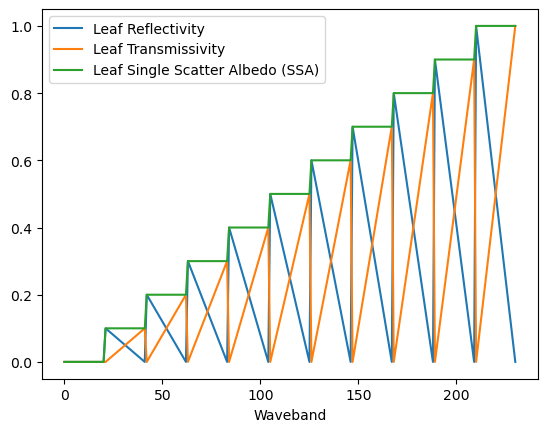

In [7]:
# use numpy to recreate the values I used
m = 11
n = 21
ssa_arr = np.linspace(0, 1, m)
t_vals = np.linspace(0, 1, n)
r_arr, t_arr = np.zeros((m, n)), np.zeros((m, n))
for i in range(m):
    ssa = ssa_arr[i]
    for j in range(n):
        t = t_vals[j]
        r = 1 - t
        r, t = r * ssa, t * ssa
        r_arr[i, j], t_arr[i, j] = r, t
r, t = r_arr.flatten(), t_arr.flatten()

plt.plot()
plt.plot(r, label='Leaf Reflectivity')
plt.plot(t, label='Leaf Transmissivity')
plt.plot(r+t, label='Leaf Single Scatter Albedo (SSA)')
plt.xlabel('Waveband')
plt.legend()
plt.show()

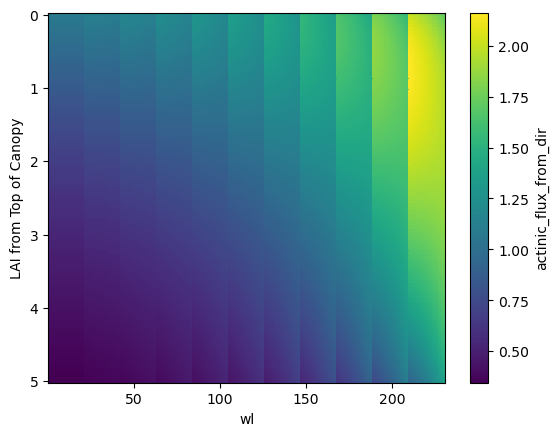

In [8]:
# open dataset using xarray
ds10 = xr.open_dataset('compare_num_streams/compare_num_streams_10.nc')

# use xarray default plotting function
ds10['actinic_flux_from_dir'].plot()
plt.gca().invert_yaxis()
plt.ylabel('LAI from Top of Canopy')

# set ticks to LAI instead of geometric height
plt.yticks([0,20,40,60,80,100], [0,1,2,3,4,5])
plt.show()

And this quick plot shows the basics. We see that higher leaf single scatter albedo (SSA) means that actinic flux (W/m^2) stays higher as we go down the canopy than the more strongly absorbing leaves modelled by the left side. Further, within the "columns" of constant SSA, we see that there is variability as reflection/transmission becomes preferred.

There are 4 output variables that I'll be tracking. Net Flux and Actinic Flux, and from Top-of-Canopy diffuse or direct radiation. Net flux is flux across a horizontal surface, and actinic flux is flux through a sphere, with no directional weighting. 

My model is a tad more sophisticated than the 2-stream implementation shown above; it allows for any even number of streams. We would expect convergence as the number of streams gets large - but when are approximations good? The following plots show error relative to the 10-stream. The following exercises use a canopy similar to a mid-latitude forests, with the sun high in the sky.

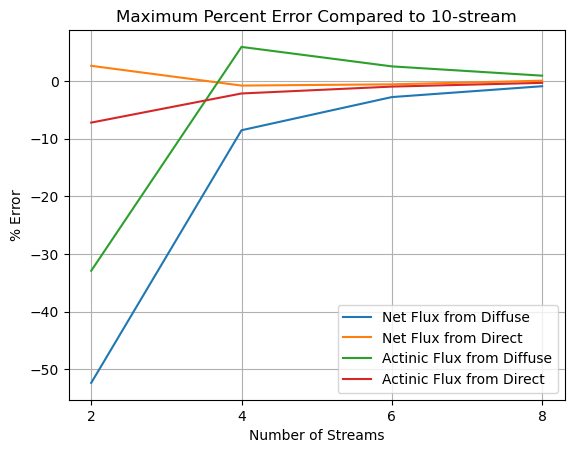

In [9]:
ds = []
for i in [2,4,6,8]:
    ds.append(xr.open_dataset('compare_num_streams/compare_num_streams_' + str(i) + '.nc'))
ds10 = xr.open_dataset('compare_num_streams/compare_num_streams_10.nc')

labels = ['net_flux_from_dif', 'net_flux_from_dir', 'actinic_flux_from_dif', 'actinic_flux_from_dir']
pretty_labels = ['Net Flux from Diffuse', 'Net Flux from Direct', 'Actinic Flux from Diffuse', 'Actinic Flux from Direct']

# make plot
plt.plot()

for pretty_label, out in enumerate(labels):
    error = []
    for ds_2n in ds:
        # compute percent error
        diff = ((ds_2n - ds10)/ds10)[out] * 100
        max_index = np.abs(diff.to_numpy().flatten()).argmax()
        err = diff.to_numpy().flatten()[max_index]
        error.append(err)

    plt.plot([2, 4, 6, 8], error, label=pretty_labels[pretty_label])
    
plt.legend()
plt.title('Maximum Percent Error Compared to 10-stream')
plt.xticks([2,4,6,8])
plt.xlabel('Number of Streams')
plt.ylabel(r'$\%$ Error')
plt.grid()
plt.show()

Okay, so the 2-stream is pretty bad, at least at dealing with incoming diffuse radiation. By the time we get the 6-stream, extra computations aren't really useful. 

Where is this error in the canopy? Let's make some more plots. Let's not do percent error this time, just regular differencing.

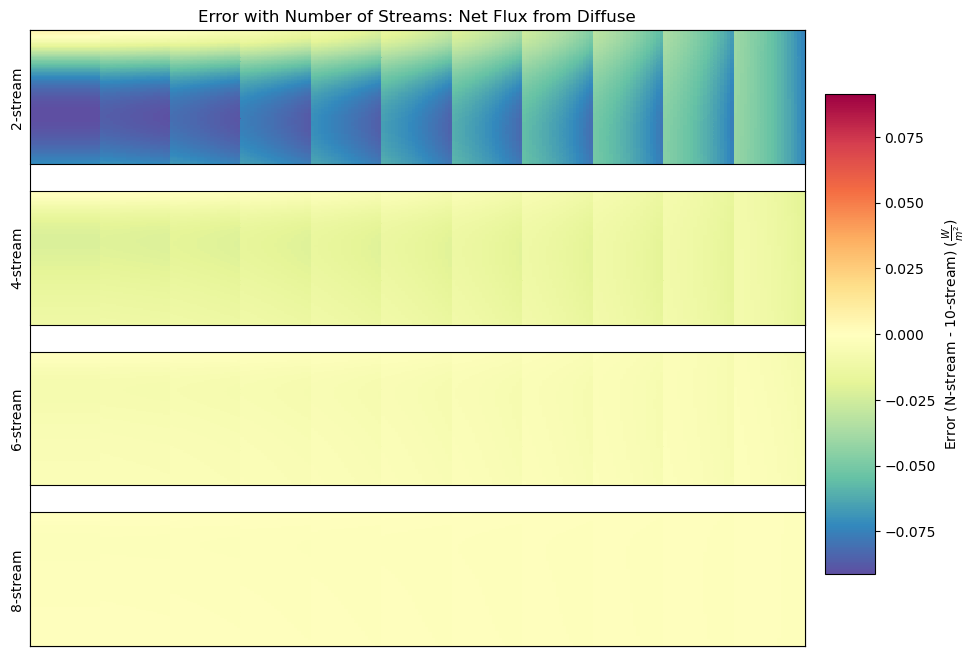

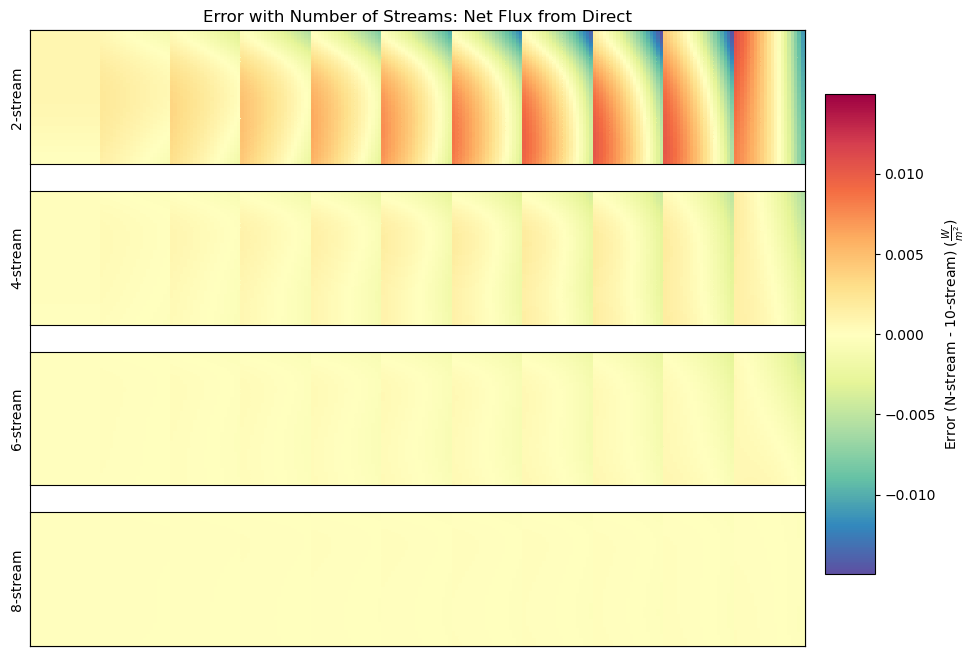

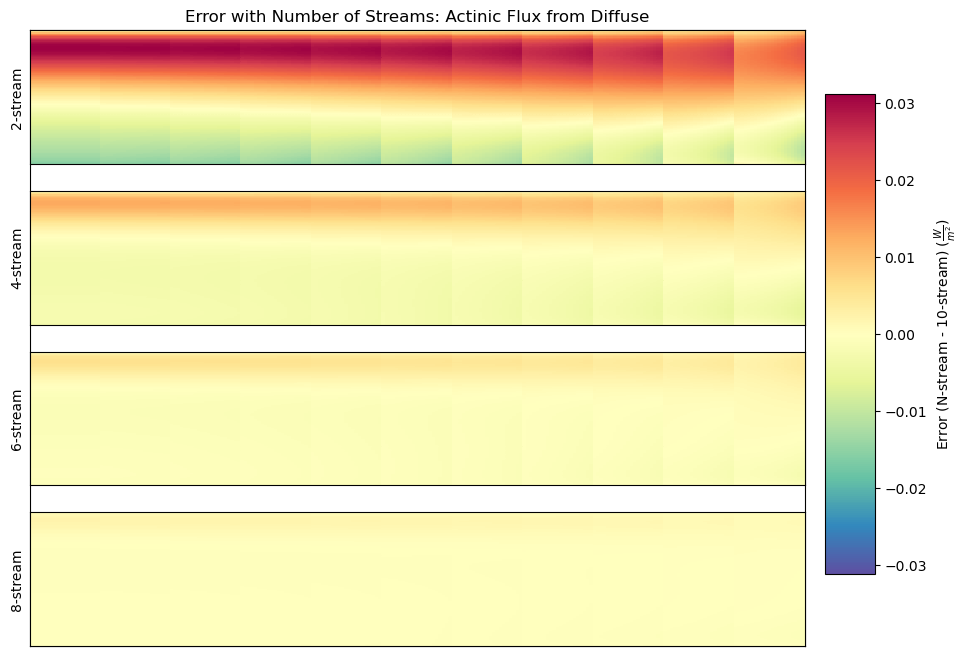

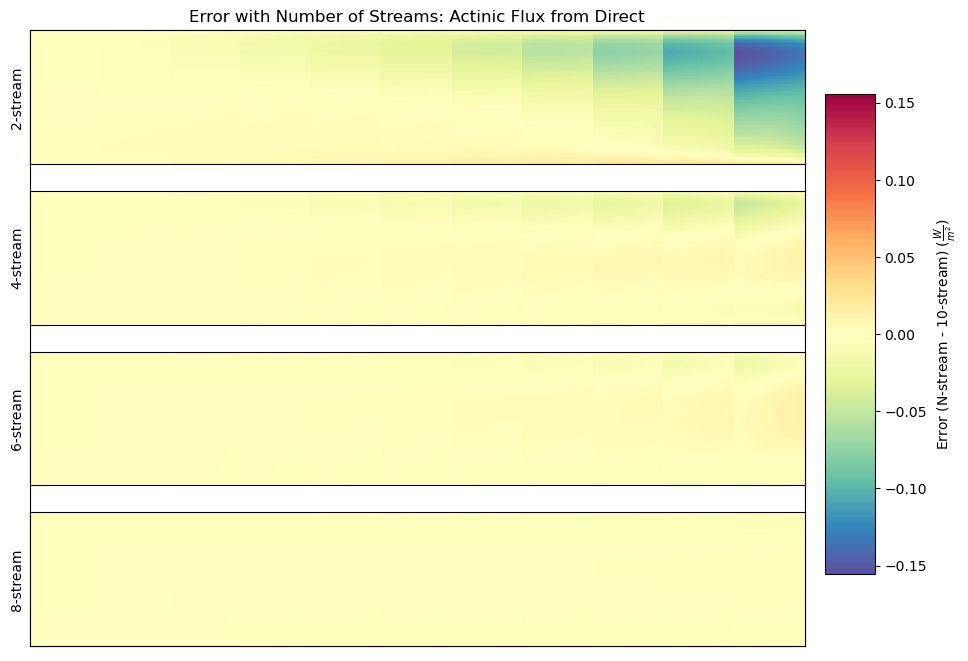

In [10]:
for pretty_label, label in enumerate(labels):

    # make a big figure
    fig = plt.figure(figsize=(10,8))
    
    plt.title('Error with Number of Streams: ' + pretty_labels[pretty_label])
    plt.yticks([])
    plt.xticks([])

    # compute colorbar scale
    vmax = np.abs((ds[0][label] - ds10[label]).to_numpy()).max()

    # for each n-stream outpute
    for i, ds_2n in enumerate(ds):
        ax = fig.add_subplot(4,1,i+1)
        diff = (ds_2n[label] - ds10[label]).to_numpy()

        ax.set_ylabel(str(2*(i+1)) + '-stream')
        cf = ax.pcolormesh(diff, vmin=-vmax, vmax = vmax, cmap=mpl.cm.Spectral_r)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.invert_yaxis()

    # add colorbat
    cax = fig.add_axes([0.92,0.2,0.05,0.6])
    plt.colorbar(cf, cax=cax, orientation='vertical', label=r'Error (N-stream - 10-stream) $(\frac{W}{m^2})$')
    
    plt.show()


From these, it's really obvious that there are definite differences between the diffuse radiation and the direct beam from the sun, and how these interplay with where error is.

Now that we've done some error analysis, let's use some 6-stream output to analyze another assumption CRT models often make, isotropic scattering. To do this, we make some scattering phase functions which bias forward or backscattering, and see how much outcome differs by. 

We make these contour plots this time, for fun!

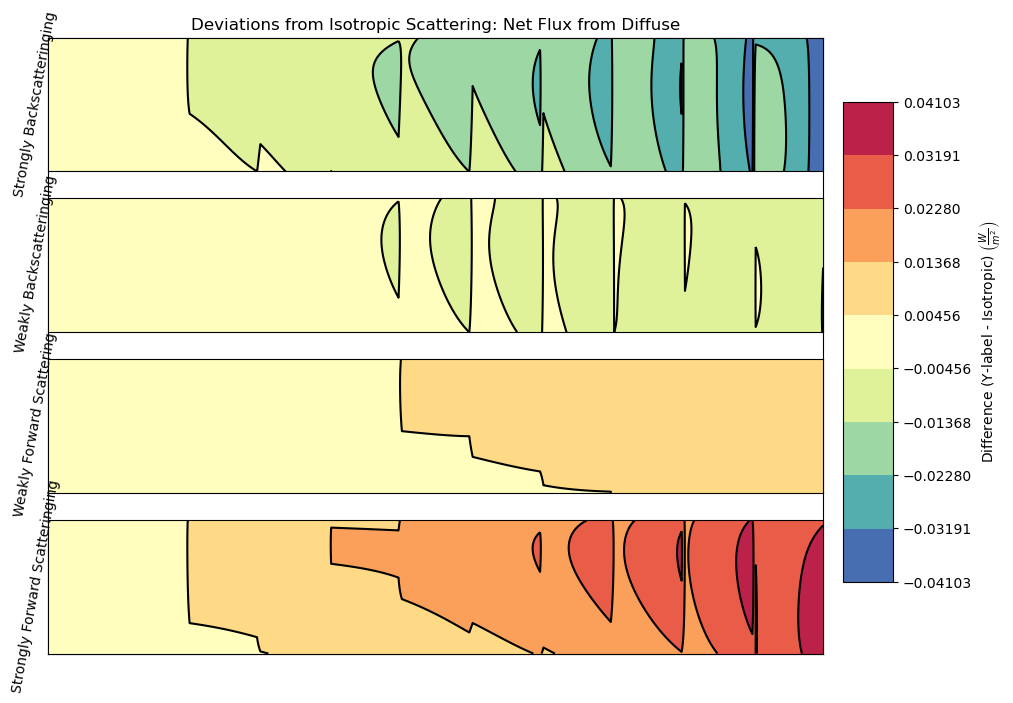

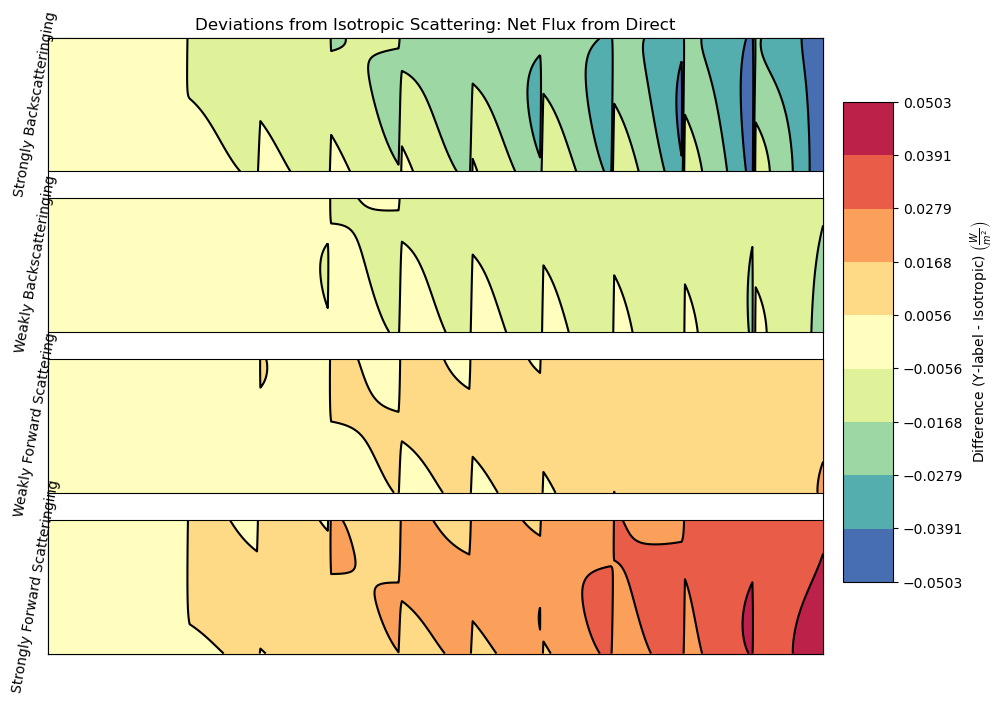

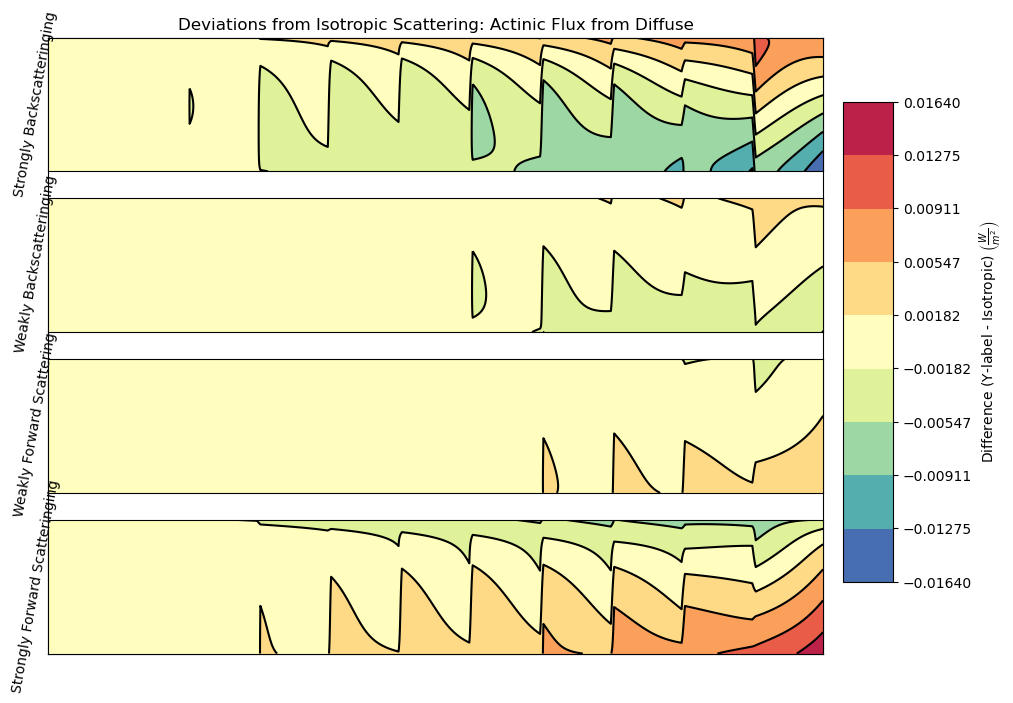

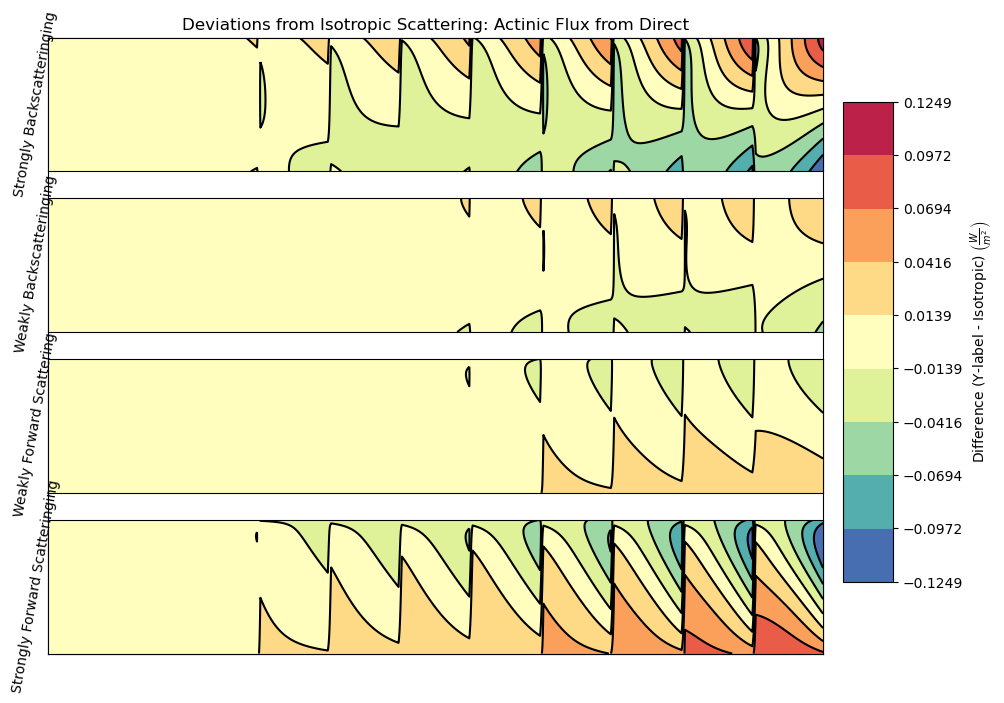

In [11]:
# read in the files
g_arr = [-.6,-.3,.3,.6]
ds = []
for g in g_arr:
    ds.append(xr.open_dataset('compare_scattering_phase_fn/g_' + str(g) + '.nc'))
ds_isotropic = xr.open_dataset('compare_scattering_phase_fn/g_0.nc')

labels = ['net_flux_from_dif', 'net_flux_from_dir', 'actinic_flux_from_dif', 'actinic_flux_from_dir']
ylabels = ['Strongly Backscatteringing', 'Weakly Backscatteringing', 'Weakly Forward Scattering', 'Strongly Forward Scatteringing']

# for each of the 4 output variables
for pretty_label, label in enumerate(labels):

    # set up figure
    fig = plt.figure(figsize=(10,8))
    plt.title('Deviations from Isotropic Scattering: ' + pretty_labels[pretty_label])
    plt.yticks([])
    plt.xticks([])

    # compute colobar parameters
    vmax = 0
    for ds_g in ds:
        vmax = max(np.abs((ds_g[label] - ds_isotropic[label]).to_numpy()).max(), vmax) 
    
    for i, ds_g in enumerate(ds):
        # make subplot
        ax = fig.add_subplot(4,1,i+1)
        diff = (ds_g[label] - ds_isotropic[label]).to_numpy()

        ax.set_ylabel(ylabels[i], rotation=80)
        cf = ax.contourf(diff, np.linspace(-vmax, vmax, 10), cmap=mpl.cm.Spectral_r)
        ax.contour(diff, np.linspace(-vmax, vmax, 10), colors = 'black', linestyles='-') # to get lines in between
        ax.set_yticks([])
        ax.set_xticks([])
        ax.invert_yaxis()
    
    cax = fig.add_axes([0.92,0.2,0.05,0.6])
    plt.colorbar(cf, cax=cax, orientation='vertical', label=r'Difference (Y-label - Isotropic) $\left(\frac{W}{m^2}\right)$')
    plt.show()


So only quite strongly forward/backscattering makes a big difference. Unfortunately, I have no idea what realistic values are, since I can't find any good literature on it. Also, the largest effects are to the right, where SSA is quite high.

What we've seen is that changing scattering phase function has a varied effect depending on reflection/transmission and the output variable. However, it's not clear exactly how. We now use scikit-learn to try to gain some insight. 

I randomized inputs to the CRT model, and thus got lots of randomized outputs. We use a random forest regression to find out which input variables contribute most to the outputs.

Let's see what one file looks like

In [12]:
ds = xr.open_dataset('rand_data/_100_.nc')
ds

<xarray.Dataset>
Dimensions:                            (wl: 100, z: 11)
Coordinates:
  * wl                                 (wl) float64 0.995 1.985 ... 98.02 99.0
  * z                                  (z) float64 0.0 10.0 20.0 ... 90.0 100.0
Data variables: (12/22)
    soil_r                             (wl) float64 ...
    leaves_r                           (wl) float64 ...
    leaves_t                           (wl) float64 ...
    down_flux_from_dif                 (z, wl) float64 ...
    up_flux_from_dif                   (z, wl) float64 ...
    net_flux_from_dif                  (z, wl) float64 ...
    ...                                 ...
    leaves_r_strong_bilambertial       float64 ...
    leaves_t_forward_scatter_fraction  float64 ...
    leaves_t_strong_bilambertial       float64 ...
    leaves_orient_mean                 float64 ...
    leaves_orient_std                  float64 ...
    leaves_orient_skew                 float64 ...

Our goal is to read in each xarray .nc file and add it to 2 pandas dataframes, one for the input variables and one for the output variables. Each row would be a single "pixel" in the above plots.

In [13]:
# reshape our arrays

n_wl = len(ds.wl)
n_z = len(ds.z)

# floats, single digit

# solar zenith angle, radians off of vertical
sza = np.full(n_z * n_wl, ds['sza']) 

# information about the phase function, forward scatter fraction (fscatter) and a quantity related to how strong the bi-lambertian scattering is (bilambert) for both reflection (r) and transmission (t)
r_fscatter = np.full(n_z * n_wl, ds['leaves_r_forward_scatter_fraction'])
r_bilambert = np.full(n_z * n_wl, ds['leaves_r_strong_bilambertial'])
t_fscatter = np.full(n_z * n_wl, ds['leaves_t_forward_scatter_fraction'])
t_bilambert = np.full(n_z * n_wl, ds['leaves_t_strong_bilambertial'])

# information about the leaf orientation function. Since it's a probability density function, we can find mean, standard deviation, skewness
l_mla = np.full(n_z * n_wl, ds['leaves_orient_mean'])
l_std = np.full(n_z * n_wl, ds['leaves_orient_std'])
l_skew = np.full(n_z * n_wl, ds['leaves_orient_skew'])

# 1D arrays (change with wl)
# leaf reflectivity/transmissivity
leaf_t = np.repeat(ds['leaves_t'], n_z)
leaf_r = np.repeat(ds['leaves_r'], n_z)

# soil reflectivity
soil_r = np.repeat(ds['soil_r'], n_z)

# 1D arrays (change with LAI). We want to collapse them differently so they don't line up with the other values
# Leaf Area Index
lai_above = np.repeat(ds['leaves_vertical_profile'].to_numpy().reshape(n_z, 1), n_wl, axis=1).flatten(order='F') # lai above layer of interest
lai_below = lai_above[-1] - lai_above # lai below layer of interest

# compile them together into input dataframe
dfx = pd.DataFrame()

dfx['sza'] = sza
dfx['r_fscatter'] = r_fscatter
dfx['r_bilambert'] = r_bilambert
dfx['t_fscatter'] = t_fscatter
dfx['t_bilambert'] = t_bilambert
dfx['l_mla'] = l_mla
dfx['l_std'] = l_std
dfx['l_skew'] = l_skew
dfx['leaf_t'] = leaf_t
dfx['leaf_r'] = leaf_r
dfx['soil_r'] = soil_r
dfx['lai_above'] = lai_above
dfx['lai_below'] = lai_below


# Format y

# flatten properly
net_dif = ds['net_flux_from_dif'].to_numpy().flatten(order="F")
net_dir = ds['net_flux_from_dir'].to_numpy().flatten(order="F")
actinic_dif = ds['actinic_flux_from_dif'].to_numpy().flatten(order="F")
actinic_dir = ds['actinic_flux_from_dir'].to_numpy().flatten(order="F")

# compile them together
dfy = pd.DataFrame()

dfy['net_dif'] = net_dif
dfy['net_dir'] = net_dir
dfy['actinic_dif'] = actinic_dif
dfy['actinic_dir'] = actinic_dir

Let's take a look at our dataframes

In [14]:
dfx

sza  r_fscatter  r_bilambert  t_fscatter  t_bilambert     l_mla  \
0     0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
1     0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
2     0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
3     0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
4     0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
...        ...         ...          ...         ...          ...       ...   
1095  0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
1096  0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
1097  0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
1098  0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   
1099  0.585124    0.586958     0.399469    0.594181     0.413554  1.083356   

         l_std   l_skew    leaf_t    leaf_r    soil_r  lai_above  lai_below  
0     0.358023 -0.71524  0.002247  0.045154  0.249978   0.000000   3.274491  
1     0.358023 -0.71524  0.002247  0.045154  0.249978   0.327449   2.947042  
2     0.358023 -0.71524  0.002247  0.045154  0.249978   0.654898   2.619593  
3     0.358023 -0.71524  0.002247  0.045154  0.249978   0.982347   2.292143  
4     0.358023 -0.71524  0.002247  0.045154  0.249978   1.309796   1.964694  
...        ...      ...       ...       ...       ...        ...        ...  
1095  0.358023 -0.71524  0.822873  0.084251  0.182089   1.964694   1.309796  
1096  0.358023 -0.71524  0.822873  0.084251  0.182089   2.292143   0.982347  
1097  0.358023 -0.71524  0.822873  0.084251  0.182089   2.619593   0.654898  
1098  0.358023 -0.71524  0.822873  0.084251  0.182089   2.947042   0.327449  
1099  0.358023 -0.71524  0.822873  0.084251  0.182089   3.274491   0.000000  

[1100 rows x 13 columns]

In [15]:
dfy

net_dif   net_dir  actinic_dif  actinic_dir
0     0.976985  0.988902     0.325884     1.224964
1     0.829814  0.863136     0.273234     1.073934
2     0.704712  0.753145     0.229882     0.941381
3     0.598015  0.656948     0.194186     0.825166
4     0.506662  0.572803     0.164819     0.723391
...        ...       ...          ...          ...
1095  0.502414  0.540351     0.320357     1.533059
1096  0.488122  0.519587     0.294876     1.425592
1097  0.474994  0.500911     0.269240     1.310124
1098  0.463028  0.484202     0.243366     1.187460
1099  0.452229  0.469358     0.217137     1.058017

[1100 rows x 4 columns]

We see that they have the same number of rows, and the columns of dfx are the input variables, columns of dfy are the corresponding output variables. 

We read in other files, reshape them, and concatenate to the bottom of the dataframe

In [16]:
# read in the files
for i in range(100, 298):
    ds = xr.open_dataset('rand_data/_' + str(i) + '_.nc')

    # reshape our arrays
    
    n_wl = len(ds.wl)
    n_z = len(ds.z)
    
    # floats, single digit
    
    # solar zenith angle, radians off of vertical
    sza = np.full(n_z * n_wl, ds['sza']) 
    
    # information about the phase function, forward scatter fraction and a quantity related to how strong the bi-lambertian scattering is
    # basically just higher-order characterizations of the phase function
    r_fscatter = np.full(n_z * n_wl, ds['leaves_r_forward_scatter_fraction'])
    r_bilambert = np.full(n_z * n_wl, ds['leaves_r_strong_bilambertial'])
    t_fscatter = np.full(n_z * n_wl, ds['leaves_t_forward_scatter_fraction'])
    t_bilambert = np.full(n_z * n_wl, ds['leaves_t_strong_bilambertial'])
    
    # information about the orientation function. Since it's a probability density function, we can find mean, standard deviation, skewness
    l_mla = np.full(n_z * n_wl, ds['leaves_orient_mean'])
    l_std = np.full(n_z * n_wl, ds['leaves_orient_std'])
    l_skew = np.full(n_z * n_wl, ds['leaves_orient_skew'])
    
    # 1D arrays (change with wl)
    # leaf reflectivity/transmissivity
    leaf_t = np.repeat(ds['leaves_t'], n_z)
    leaf_r = np.repeat(ds['leaves_r'], n_z)
    
    # soil reflectivity
    soil_r = np.repeat(ds['soil_r'], n_z)
    
    # 1D arrays (change with LAI). We want to collapse them differently so they don't line up with the other values
    # Leaf Area Index
    lai_above = np.repeat(ds['leaves_vertical_profile'].to_numpy().reshape(n_z, 1), n_wl, axis=1).flatten(order='F') # lai above layer of interest
    lai_below = lai_above[-1] - lai_above # lai below layer of interest
    
    # compile them together into input dataframe
    dfx2 = pd.DataFrame()
    
    dfx2['sza'] = sza
    dfx2['r_fscatter'] = r_fscatter
    dfx2['r_bilambert'] = r_bilambert
    dfx2['t_fscatter'] = t_fscatter
    dfx2['t_bilambert'] = t_bilambert
    dfx2['l_mla'] = l_mla
    dfx2['l_std'] = l_std
    dfx2['l_skew'] = l_skew
    dfx2['leaf_t'] = leaf_t
    dfx2['leaf_r'] = leaf_r
    dfx2['soil_r'] = soil_r
    dfx2['lai_above'] = lai_above
    dfx2['lai_below'] = lai_below
    
    
    # Format y
    
    # flatten properly
    net_dif = ds['net_flux_from_dif'].to_numpy().flatten(order="F")
    net_dir = ds['net_flux_from_dir'].to_numpy().flatten(order="F")
    actinic_dif = ds['actinic_flux_from_dif'].to_numpy().flatten(order="F")
    actinic_dir = ds['actinic_flux_from_dir'].to_numpy().flatten(order="F")
    
    # compile them together
    dfy2 = pd.DataFrame()
    
    dfy2['net_dif'] = net_dif
    dfy2['net_dir'] = net_dir
    dfy2['actinic_dif'] = actinic_dif
    dfy2['actinic_dir'] = actinic_dir

    # concatenate to big dataframe
    dfx = pd.concat([dfx, dfx2])
    dfy = pd.concat([dfy, dfy2])

And we should now have lots of rows in both dataframes.

In [17]:
print(len(dfx.index), len(dfy.index))

218900 218900


So we are all set to apply the random forest regression. Let's start with net flux from diffuse radiation. Note that it may take a while to run. Note also that this is a random forest regression - I'll fix the seed so that results are reproducible.

In [18]:
X, y = dfx.values, dfy['net_dif']

# run model
model = RandomForestRegressor(random_state = random.seed(1234))
model.fit(X, y);

In [19]:
# Define a quick plotting function
# NOTE: Some of this function is not directly my code
def plot_importance(model, x_cols, ax):

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=x_cols)
    forest_importances = forest_importances.sort_values(ascending=True) 

    forest_importances.plot.barh(yerr=std, ax=ax)
    ax.set_ylabel("Feature")
    ax.set_xlabel("Feature Importance")
    ax.set_xscale('log')
    
    return forest_importances

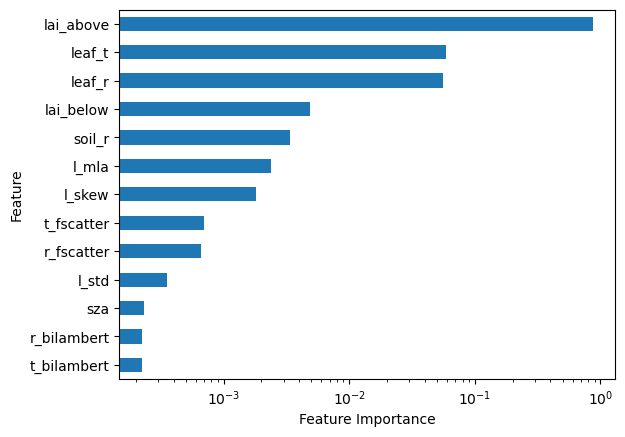

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_importance(model, dfx.columns, ax);

We see that, perhaps not surprisingly, the most important factors for predicting what the contribution to net flux at a given waveband, canopy level by the top of canopy diffuse radiation is how deep in the canopy you are. Also, the obvious leaf optical properties, reflectance and transmittance play a large role. 

After that, the variables become quite unimportant. The leaves below the level of interest, soil reflectivity, and mean leaf angle all have a pretty small impact on the output value. All information about the phase function is negligible.

Note that, since this is the contribution from diffuse, solar zenith angle (sza) should have no effect, as top of canopy diffuse radiation is assumed isotropic. These models are imperfect, but show a reasonable sketch of the importance. 

Let's repeat for the other 3 outputs!

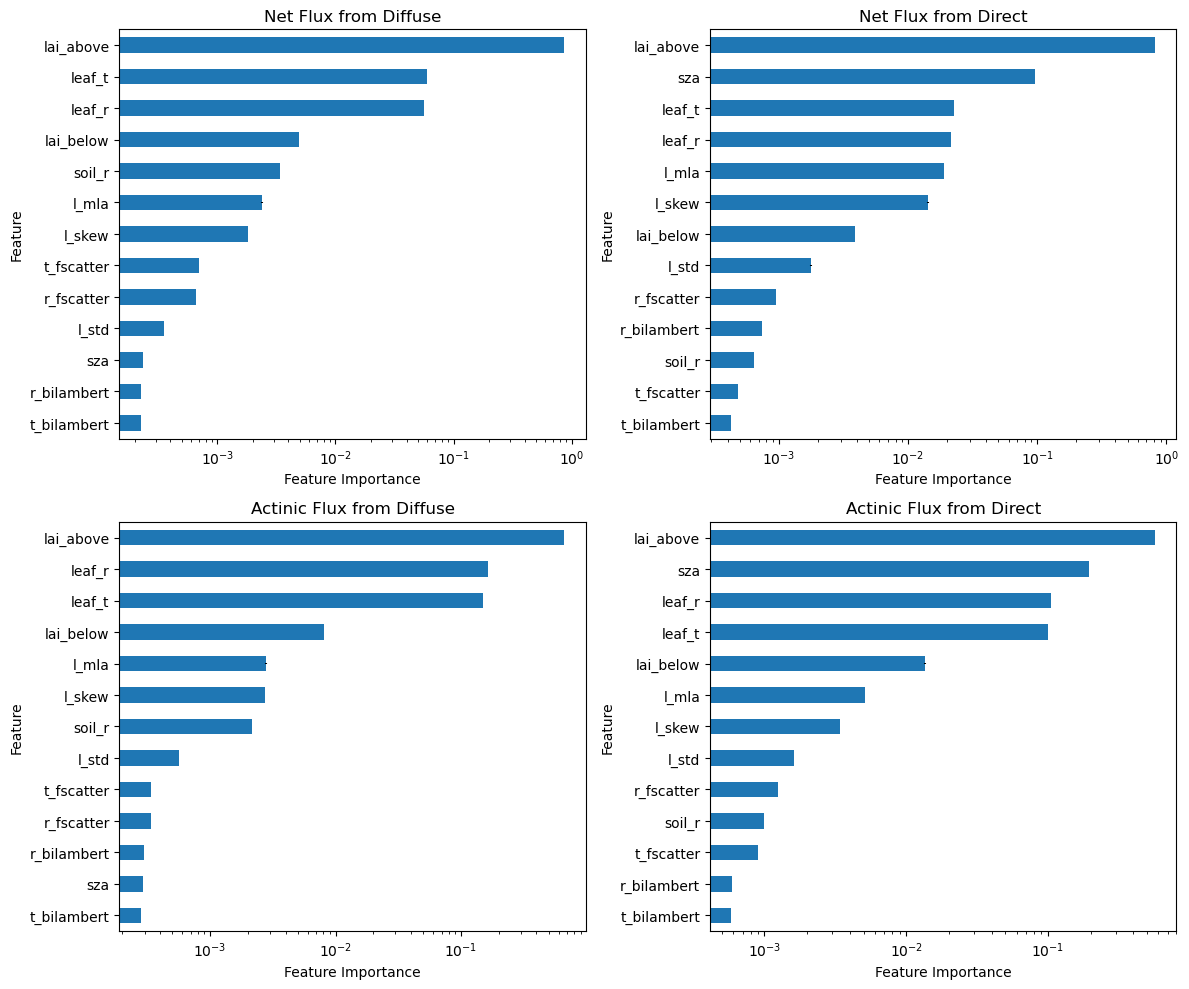

In [21]:
# create figure
fig = plt.figure(figsize=(12,10))

# plot the one already computed
ax = fig.add_subplot(221)
ax.set_title('Net Flux from Diffuse')
plot_importance(model, dfx.columns, ax);

vars = ['net_dir', 'actinic_dif', 'actinic_dir']
titles = ['Net Flux from Direct', 'Actinic Flux from Diffuse', 'Actinic Flux from Direct']

# loop through the other 3 output variables, run the RFR, make quick plot
for i, var in enumerate(vars):
    y = dfy[var]

    model = RandomForestRegressor(random_state = random.seed(1234))
    model.fit(X, y);
    
    ax = fig.add_subplot(2,2,i+2)
    ax.set_title(titles[i])
    plot_importance(model, dfx.columns, ax);

fig.tight_layout()
plt.show()    

Looking at the above plots, we see that there are clear differences for incoming direct radiation on the right side versus diffuse on the left side. In particular, the only values that really matter for diffuse are LAI above, reflectivity, transmissivity, and maybe LAI below. 

For direct, solar zenith angle matters a lot, and mean, skewness of the orientation function matter a little, especially for net flux.

One slight adjustment, because the values were randomly generated, they may be unrealistic. Let's filter the data and rerun. Let's consider a typical Wisconsin deciduous forest in mid-summer, thinking of shortwave radiation. So, we can say that:

Leaf reflectance, transmittance values shouldn't exceed .5 for any waveband. 

Mean Leaf Angle should be between 15, 55 degrees.

Solar zenith angle should be above 22 degrees. 

Total LAI should be within 2-5

In [22]:
# make df with both x,y variables
df = dfx.copy(deep=True)
df['net_dif'] = dfy['net_dif']
df['net_dir'] = dfy['net_dir']
df['actinic_dif'] = dfy['actinic_dif']
df['actinic_dir'] = dfy['actinic_dir']

# filter by the appropriate variables, as described above
df = df.where(df['leaf_r'] < 0.5).where(df['leaf_t'] < 0.5)
df = df.where(15 < df['l_mla'] * 180 / np.pi).where(df['l_mla'] * 180 / np.pi < 55)
df = df.where(df['sza'] * 180 / np.pi > 22)
df = df.where(df['lai_above'] + df['lai_below'] > 2).where(df['lai_above'] + df['lai_below'] < 5)
df = df.dropna()
df

sza  r_fscatter  r_bilambert  t_fscatter  t_bilambert     l_mla  \
0     0.604334    0.486774     0.389256    0.418508     0.429825  0.519876   
1     0.604334    0.486774     0.389256    0.418508     0.429825  0.519876   
2     0.604334    0.486774     0.389256    0.418508     0.429825  0.519876   
3     0.604334    0.486774     0.389256    0.418508     0.429825  0.519876   
4     0.604334    0.486774     0.389256    0.418508     0.429825  0.519876   
...        ...         ...          ...         ...          ...       ...   
1051  0.883681    0.322052     0.435482    0.259231     0.475180  0.772944   
1052  0.883681    0.322052     0.435482    0.259231     0.475180  0.772944   
1053  0.883681    0.322052     0.435482    0.259231     0.475180  0.772944   
1054  0.883681    0.322052     0.435482    0.259231     0.475180  0.772944   
1055  0.883681    0.322052     0.435482    0.259231     0.475180  0.772944   

         l_std    l_skew    leaf_t    leaf_r    soil_r  lai_above  lai_below  \
0     0.383670  0.979979  0.008910  0.085481  0.281390   0.000000   3.666428   
1     0.383670  0.979979  0.008910  0.085481  0.281390   0.366643   3.299785   
2     0.383670  0.979979  0.008910  0.085481  0.281390   0.733286   2.933143   
3     0.383670  0.979979  0.008910  0.085481  0.281390   1.099928   2.566500   
4     0.383670  0.979979  0.008910  0.085481  0.281390   1.466571   2.199857   
...        ...       ...       ...       ...       ...        ...        ...   
1051  0.538157  0.148809  0.498231  0.418795  0.211236   2.304167   1.536111   
1052  0.538157  0.148809  0.498231  0.418795  0.211236   2.688195   1.152084   
1053  0.538157  0.148809  0.498231  0.418795  0.211236   3.072223   0.768056   
1054  0.538157  0.148809  0.498231  0.418795  0.211236   3.456251   0.384028   
1055  0.538157  0.148809  0.498231  0.418795  0.211236   3.840279   0.000000   

       net_dif   net_dir  actinic_dif  actinic_dir  
0     0.958383  0.979621     0.330774     1.255603  
1     0.804395  0.883967     0.264363     1.138772  
2     0.680792  0.797232     0.215018     1.031669  
3     0.579808  0.718663     0.177928     0.933952  
4     0.495849  0.647535     0.149743     0.845144  
...        ...       ...          ...          ...  
1051  0.422187  0.427336     0.290507     1.354785  
1052  0.408297  0.397513     0.261788     1.209497  
1053  0.395883  0.371795     0.233397     1.065410  
1054  0.384945  0.349744     0.205016     0.921950  
1055  0.375500  0.330998     0.176273     0.778013  

[45386 rows x 17 columns]

Looks like we're down to a lot less rows, that should make the RFR run faster! Let's reorganize our dataframes and rerun.

In [23]:
dfy = pd.DataFrame()
    
dfy['net_dif'] = df['net_dif']
dfy['net_dir'] = df['net_dir']
dfy['actinic_dif'] = df['actinic_dif']
dfy['actinic_dir'] = df['actinic_dir']

dfx = df
dfx = dfx.drop(['net_dif','net_dir','actinic_dif','actinic_dir'], axis=1)

In [24]:
print(len(dfx.index), len(dfy.index))

45386 45386


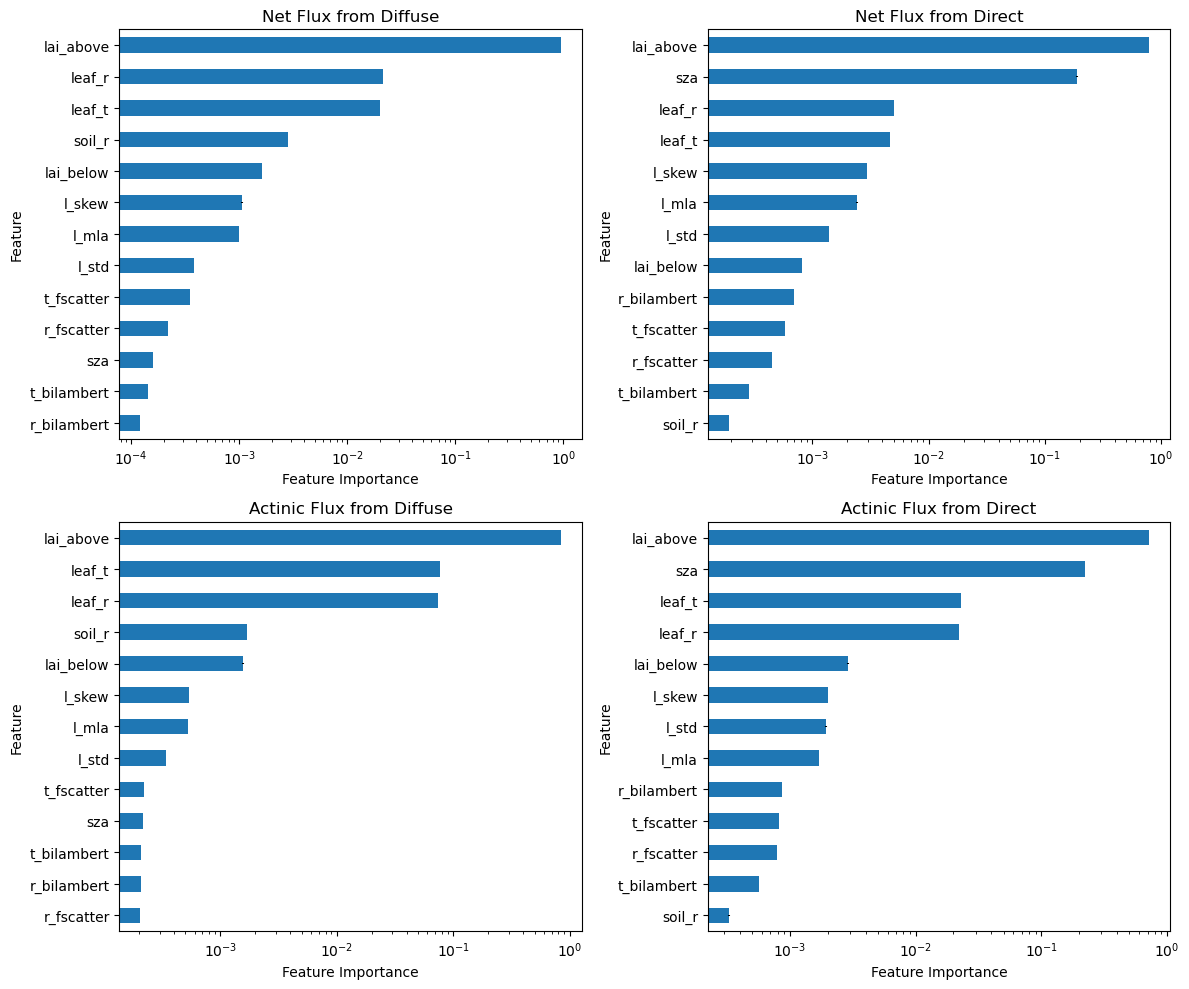

In [25]:
X = dfx.values

fig = plt.figure(figsize=(12,10))

vars = ['net_dif', 'net_dir', 'actinic_dif', 'actinic_dir']
titles = ['Net Flux from Diffuse', 'Net Flux from Direct', 'Actinic Flux from Diffuse', 'Actinic Flux from Direct']

for i, var in enumerate(vars):
    y = dfy[var]

    model = RandomForestRegressor(random_state = random.seed(1234))
    model.fit(X, y);
    
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(titles[i])
    plot_importance(model, dfx.columns, ax);

fig.tight_layout()
plt.show()    

Okay, that didn't actually change that much.

Punchline: 

If you want a CRT model, the inputs that are important differ based on what outputs you want. In particular, it appears that higher-order information about the orientation and phase functions are only negligibly important. 